In [2]:
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# if NOT working in colab
data_dir = './data'

# if working in colab
# data_dir = './'

df_skill_type = pd.read_csv(os.path.join(data_dir, 'NOC_skilltype.csv'))
df_major_group = pd.read_csv(os.path.join(data_dir, './NOC_majorgroup.csv'))
df_minor_group = pd.read_csv(os.path.join(data_dir, './NOC_minorgroup.csv'))
df = pd.read_csv(os.path.join(data_dir, './noc_data_get_byws_dealing_slash.csv'))
df.head()

,Noc_code,job_title,group_title,lead_statement,main_duties,Emp_req,Exclusion
0,11,Aboriginal band chief; Aboriginal band council...,Legislators;,Legislators participate in the activities of a...,Legislators perform some or all of the followi...,"Election to a legislative body, or appointment...",Commissioners - government services (in 0012 ...
1,12,Clerk of the Privy Council; First Nations band...,Senior government managers and officials;,"Senior government managers and officials plan,...",Senior government managers and officials perfo...,A university degree or college diploma is usua...,Legislators (0011);Middle managers in governme...
2,14,academic association president; academic busin...,"Senior managers health, education, social and...","Senior managers in this unit group plan, organ...",Senior managers in this unit group perform som...,A university degree or college diploma in busi...,Administrators - post-secondary education and ...
3,15,broadcasting corporation president; casino gen...,"Senior managers trade, broadcasting and other...","Senior managers in this unit group plan, organ...",Senior managers in this unit group perform som...,A university degree or college diploma in busi...,"Managers in art, culture, recreation and sport..."
4,16,CEO (chief executive officer)-manufacturing co...,"Senior managers construction, transportation,...","Senior managers in this unit group plan, organ...",Senior managers in this unit group perform som...,A university degree or college diploma in engi...,Managers in construction and facility operatio...


# Get job titles

In [4]:
df.columns

Index(['Noc_code', 'job_title', 'group_title', 'lead_statement', 'main_duties',
       'Emp_req', 'Exclusion'],
      dtype='object')

In [147]:
def preprocess_text(row, column):
    text = row[column]
    # remove redundant semi-colons
    text = text.strip(';')
    # hyphens are semantic noise, remove
    text = text.replace('-', ' ')
    return text.lower()

In [150]:
job_samples_df = pd.DataFrame(columns = ['sample_title', 'NOC_code'])
group_titles_df = pd.DataFrame(columns = ['sample_title', 'NOC_code'])

job_samples = {}
group_titles = {}

def extract_job_samples_and_group_titles(row):
    NOC_code = int(row['Noc_code'])
    
    # get group titles first
    title = row['group_title']
    group_titles[title] = NOC_code
    
    # split jobs contained in row by ';' 
    # make unique set
    # and take nonempty elements 
    jobs = [
        j for j in  row['job_title'].split('; ')
        if (j != '' and j != ' ')
    ]
    
    # change entries such as 'chairman/woman' into separate samples, 'chairman', 'chairwoman'
    for idx, job in enumerate(jobs):
        if 'man/woman' in job:
            # change original entry to 'job(man)', then append job(woman) to end of list
            jobs[idx] = job.replace('man/woman', 'man')
            jobs.append(job.replace('man/woman', 'woman'))
    
            
    # remove duplicate entries
    jobs = set(jobs)
    
    # parse counts of each job
    row['n_sample_jobs'] = len(jobs)
    
    # iterate through job and add to dictionary
    for j in jobs:
        
        if j not in job_samples:
            job_samples[j] = NOC_code

        # safe check, if job appears more than once, clause will print the both NOC Codes
        else:
            if job_samples[j] != NOC_code:
                print(j, 'repeated', job_samples[j], NOC_code)
    
    return row
   
df = df.apply(extract_job_samples_and_group_titles, axis = 1)

In [151]:
job_samples_df = pd.DataFrame(job_samples.items(), columns = ['input', 'code'])
job_samples_df['input'] = job_samples_df.apply(preprocess_text, axis = 1, args = ('input',))
job_samples_df.head(5)

,input,code
0,first nations band council member,11
1,prime minister,11
2,member of the provincial parliament (mpp),11
3,senator,11
4,metropolitan council chair,11


In [152]:
group_titles_df = pd.DataFrame(group_titles.items(), columns = ['input', 'code'])
group_titles_df['input'] = group_titles_df.apply(preprocess_text, axis = 1, args = ('input',))
group_titles_df.head(5)

,input,code
0,legislators,11
1,senior government managers and officials,12
2,"senior managers health, education, social and...",14
3,"senior managers trade, broadcasting and other...",15
4,"senior managers construction, transportation,...",16


# We left off here --> Gather contexts and base occupation

In [153]:
# train on ifidf to find keywords and base occupations. split each data point into 2 parts

## Train test split

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
 
X = train_df['input']

# from EDA NOC, not implemented here yet
# y1 = train_df.apply(first_n_digits, axis = 1, args = (1,)).astype('int')
# y2 = train_df.apply(first_n_digits, axis = 1, args = (2,)).astype('int')
# y3 = train_df.apply(first_n_digits, axis = 1, args = (3,)).astype('int')
# y4 = train_df.apply(first_n_digits, axis = 1, args = (4,)).astype('int')

# select how many digits to train on
y = y4

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1
)
corpus = list(X_train)## Train test split

NameError: name 'y4' is not defined

# Transform corpus into vectors

In [522]:
# for effient load an dstore of objects w/ large numpy arrays internally
from joblib import dump, load

# Remove highly uncommon word (freq < 5) from corpus to reduce dimensionality
vectorizer = TfidfVectorizer(min_df=5, 
                             stop_words="english",
                            lowercase=True)
vectorized_X_train = vectorizer.fit_transform(corpus)
vectorized_X_train.shape

dump(vectorizer, 'vectorizer.joblib') 

['vectorizer.joblib']

# Transform test data

In [533]:
# Transform new data using existing TFIDF model

if vectorizer is None:
    vectorizer = load('vectorizer.joblib')

vectorized_X_test = vectorizer.transform(X_test)
print(vectorized_X_test.shape)

(5464, 3430)


In [172]:
class LRScheduler:
    """
    class in charge of updating the learning rate as training progresses
    """
    def __init__(self,
                 epochs,
                 num_milestones,
                 initial_alpha=0.01,
                 min_alpha = 1e-6,
                 gamma=1,
                 cosine_oscillations=2,
                 cosine_scaling_factor=5e-6):
        cosine_oscillations = cosine_oscillations
        cosine_scaling_factor = cosine_scaling_factor
        
        # factor by which we multiply LR at each milestone
        self.gamma = gamma
        self.milestones = np.arange(epochs/num_milestones + 1, epochs, epochs/num_milestones).astype(int)
        
        self.min_alpha = min_alpha
        self.alpha = initial_alpha
        
        # changes to apply to learning rate
        self.LR_schedule = np.cos(np.linspace(0, 2*np.pi*cosine_oscillations, epochs)) * cosine_scaling_factor

    def update(self, idx):
        """
        Check if learning rate is valid (positive, and > min_alpha), then update according to self.LR_schedule
        """
        shift = self.LR_schedule[idx]
        
        # milestone?
        if idx in self.milestones:
            print(idx)
            scaled_alpha = self.alpha*self.gamma
            # validity check
        # validity check    self.alpha = scaled_alpha if self.scaled_alpha > self.min_alpha else self.min_alpha
        
        self.alpha = self.alpha + shift if self.alpha + shift > self.min_alpha else self.min_alpha 
        assert self.alpha > 0 and self.alpha > self.min_alpha, "Alpha invalid: {}".format(self.alpha)
        return self.alpha

In [173]:
from matplotlib import pyplot as plt
from tqdm import tqdm

In [175]:
scheduler = LRScheduler(cosine_oscillations = 10,
                        epochs = 4096,
                        gamma = 0.3,
                        num_milestones = 4,
                        initial_alpha = 0.01,
                        min_alpha = 0.00025)



alpha_plot = [alpha]
print(scheduler.gamma)
for idx, shift in enumerate(tqdm(LR_schedule)):
    scheduler.update(idx)
    
    alpha_plot.append(scheduler.alpha)
    


100%|██████████| 4096/4096 [00:00<00:00, 164127.38it/s]

0.3
1025
2049
3073


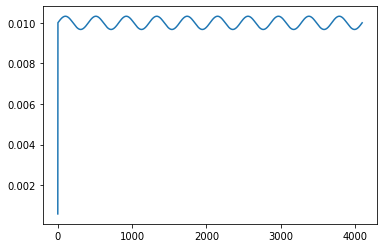

In [176]:
plt.plot(alpha_plot)